# Simulation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac, tucker
import warnings
from tensorly.cp_tensor import CPTensor
from tensorly.tucker_tensor import TuckerTensor, tucker_to_tensor
from scipy.linalg import svd
import tlviz
from itertools import product
from kneed import KneeLocator

In [2]:
np.random.seed(42)

num_sequences = 100 
num_timesteps = 10 
num_patients = 10 

tensor = np.abs(np.random.normal(0, 0.1, (num_sequences, num_timesteps, num_patients)))

t = np.arange(num_timesteps)
a = 0.2
b = 0.3
c = 0.1

for patient in range(num_patients):
    if patient < 3:
        tensor[0:2, :, patient] = a * (t[None, :] + 1) + np.abs(np.random.normal(0, 0.1, (2, num_timesteps)))

    elif 3 <= patient < 6: 
        tensor[2:6, :, patient] = b * t[None, :] + np.abs(np.random.normal(0, 0.1, (4, num_timesteps)))

    else:
        tensor[1:5, 0:5, patient] = c * t[None, 5] ** 2 - c * (t[::-1][None, 5:10] + 1) ** 2 + np.abs(np.random.normal(0, 0.1, (4, 5)))
        tensor[1:5, 5, patient] = c * t[None, 5] ** 2 + np.abs(np.random.normal(0, 0.1, (4,)))
        tensor[1:5, 6:10, patient] = - c * (t[None, 6:10] - 4) ** 2 + c * 5 ** 2 + np.abs(np.random.normal(0, 0.1, (4, 4)))

In [3]:
tensor.shape

(100, 10, 10)

## 0-1 Normalization

In [4]:
def norm_01scale(tensor):
    sum_mode_0 = np.sum(tensor, axis=0, keepdims=True)
    sum_mode_0[sum_mode_0 == 0] = 1
    return tensor / sum_mode_0

In [5]:
tensor_norm = norm_01scale(tensor)

## Scaling

In [3]:
def scaling(tensor, mode, mode1, mode2):
    scale_factors = 1 / np.sqrt(np.sum(tensor**2 , axis=(mode1, mode2)))

    shape = [1] * tensor.ndim
    shape[mode] = tensor.shape[mode]
    scale_factors = scale_factors.reshape(shape)
    
    return tensor * scale_factors

In [4]:
tensor_scaled = scaling(tensor, 2, 0, 1)

## Centering

In [6]:
def centering(tensor, mode):
    mean = np.mean(tensor, axis=mode, keepdims=True)
    return tensor - mean

In [7]:
tensor_cent = centering(tensor_norm, 1)

## Number of components

In [8]:
def visualization_corcondia(model, tensor):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    models = {}
    for rank in [1, 2, 3, 4, 5, 6]:
        models[rank] = model(tensor, rank=rank, orthogonalise=True)
    
    ax = tlviz.visualisation.scree_plot(models, tensor, metric="Core consistency")
    ax.set_ylim(0, 105)
    ax.set_title("Simulated tensor")
    ax.set_xlabel("Num of Comps.")
    
    ax.set_xticks([1, 2, 3, 4, 5, 6])

    corcondia_values = [ax.lines[0].get_ydata()[i] for i in range(6)]

    second = corcondia_values[1]
    third = corcondia_values[2]

    print(f"Corcondia value for Simulated tensor: {second}, {third}")
    
    plt.tight_layout()
    plt.show()

Corcondia value for Simulated tensor: 99.99999894627781, 66.52424597472645


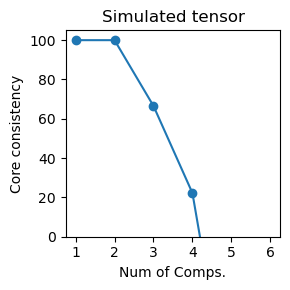

In [9]:
visualization_corcondia(parafac, tensor_cent)

In [10]:
def error(original, res):
    # res is in CP
    if isinstance(res, CPTensor):
        res = res.to_tensor()
    
    # deal with cases when res is Tucker
    if isinstance(res, TuckerTensor):
        res = tucker_to_tensor(res)
        
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)

In [11]:
def visualization_error(model, tensor):
    fig, ax = plt.subplots(figsize=(3, 3)) 

    warnings.simplefilter("ignore", UserWarning)

    errors = pd.DataFrame(columns=["Num of Comps.", "Reconstruction error"])
    for rr in np.arange(1, 10):
        model_ = model(tensor, rank=rr, orthogonalise=True)
        err = error(tensor, model_)
        errors.loc[len(errors)] = [rr, err]

    kneedle = KneeLocator(errors["Num of Comps."], errors["Reconstruction error"], curve="convex", direction="decreasing")
    elbow = kneedle.elbow
    
    sns.pointplot(data=errors, x="Num of Comps.", y="Reconstruction error", ax=ax)
    ax.set_title("Simulated tensor")
    ax.set_xticklabels(errors["Num of Comps."].astype(int))

    if elbow:
        ax.axvline(elbow - 1, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

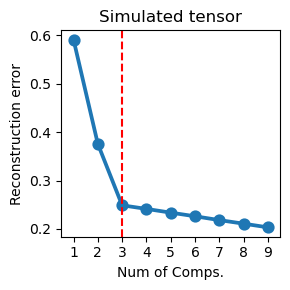

In [12]:
visualization_error(parafac, tensor_cent)

In [13]:
def decomposition_visualization(factors, patients):
    factor_labels = ["T Cells", "Days", "Patients"]
    x_labels = [range(f.shape[0]) for f in factors]
    
    num_components = factors[0].shape[1]
    
    fig, axes = plt.subplots(num_components, 3, figsize=(15, 4 * num_components))
    
    for component in range(num_components):
        for dim in range(3):
            ax = axes[component, dim]
            if dim == 0 or dim == 2:
                ax.bar(x_labels[dim], factors[dim][:, component], color='royalblue', alpha=0.8)
            else:
                ax.plot(x_labels[dim], factors[dim][:, component], marker='o', linestyle='-')
            ax.set_title(f"Component {component+1} - {factor_labels[dim]}")
            ax.set_xlabel(factor_labels[dim])
            ax.set_ylabel("Weight")
            if dim == 1:
                time_labels = [t * 10 for t in x_labels[dim]]
                ax.set_xticks(x_labels[dim])
                ax.set_xticklabels(time_labels)
                if len(time_labels) > 29:
                    step = 6
                elif len(time_labels) > 19:
                    step = 4
                elif len(time_labels) > 9:
                    step = 2 
                else:
                    step = 1 
                
                ax.set_xticks(x_labels[dim][::step])  # Reduce number of ticks
                ax.set_xticklabels(time_labels[::step]) 
            if dim == 2:
                ax.set_xticks(range(len(patients)))
                ax.set_xticklabels(patients, rotation=0, ha="right")
    
    plt.tight_layout()
    plt.show()

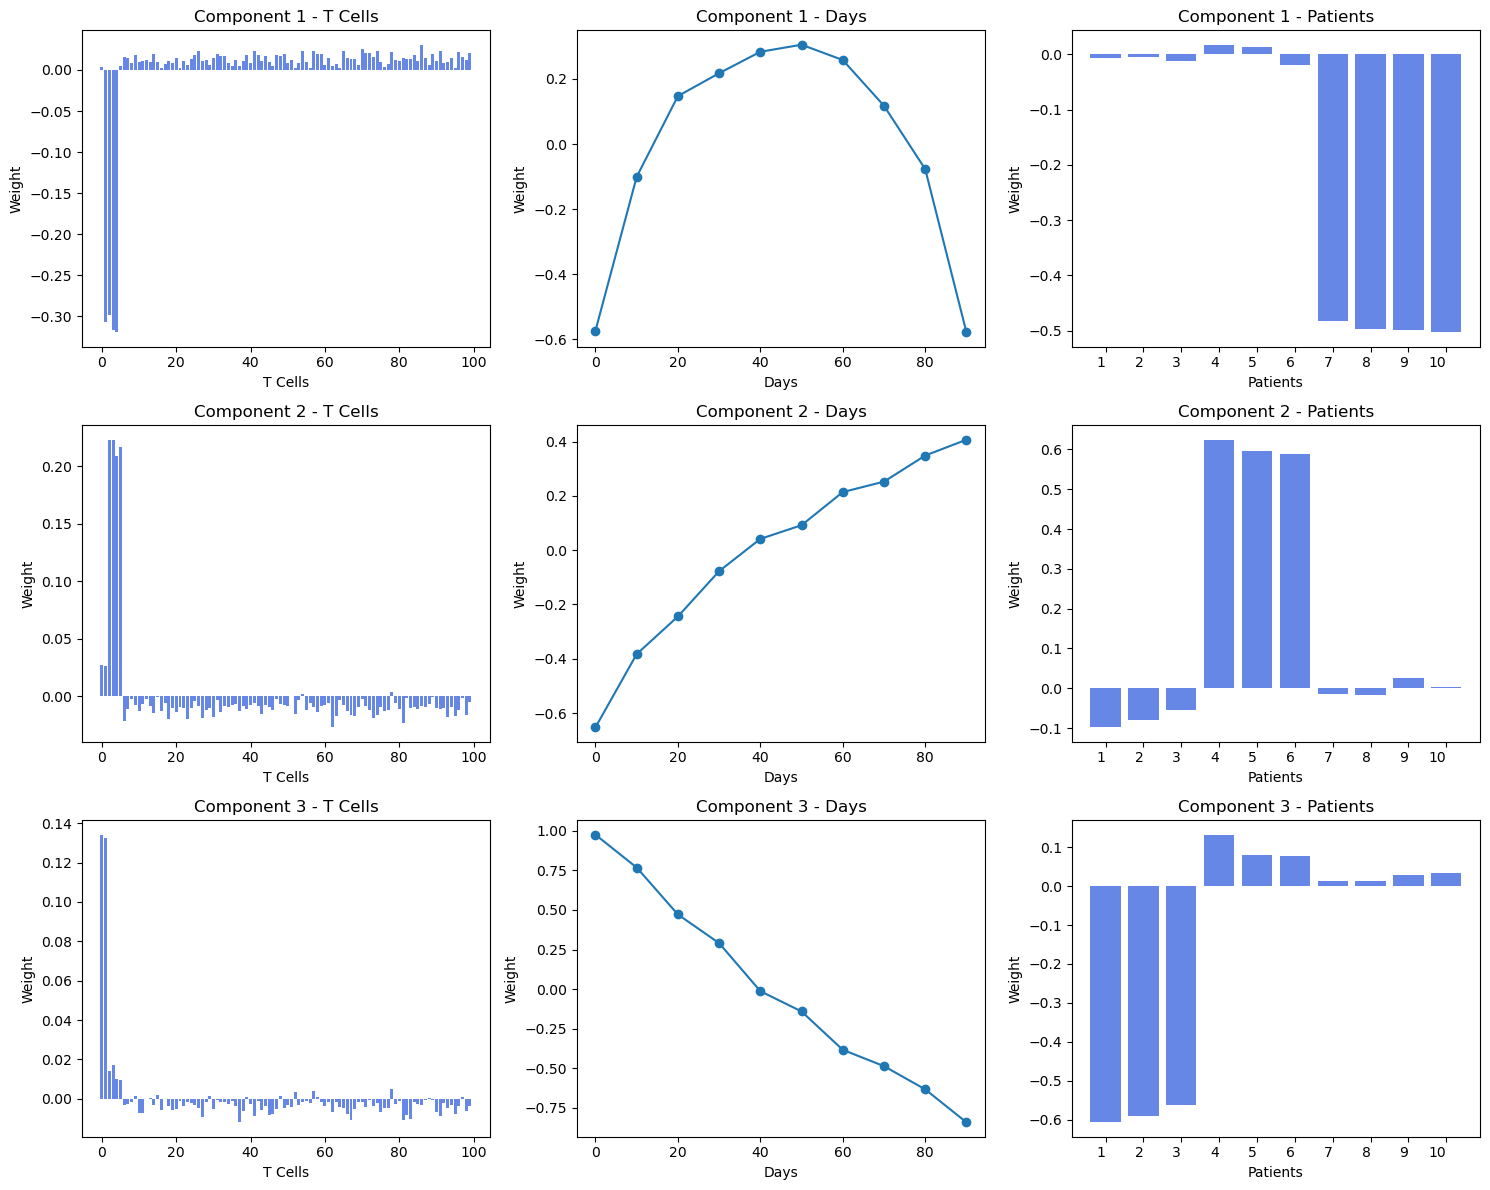

In [14]:
tensor_cent = tl.tensor(tensor_cent)
weights, factors = parafac(tensor_cent, rank=3, orthogonalise=True)
patients = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
decomposition_visualization(factors, patients)

In [15]:
best_ranks = []
best_fits = []
valid_ranks = []
tensor = tensor_cent # change tensor
model = tucker # change model

for i in range(1, tensor.shape[0]+1):
    for j in range(1, tensor.shape[1]+1):
        for k in range(1, tensor.shape[2]+1):
            if i <= j*k and j <= i*k and k <= i*j:
                valid_ranks.append([i, j, k])

valid_ranks = np.array(valid_ranks)

unique_s = np.unique(np.sum(valid_ranks, axis=1))

for s in unique_s:
    ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]

    best_fit = 0
    best_rank = []

    for rank in ranks_s:
        core_tensor, factors = model(tensor, list(rank))

        reconstructed_tensor = tl.tucker_to_tensor((core_tensor, factors))

        fit = 100 * (np.sum(tensor**2) - np.sum((tensor - reconstructed_tensor)**2)) / np.sum(tensor**2)

        if fit > best_fit:
            best_fit = fit
            best_rank = rank

    best_ranks.append(best_rank)
    best_fits.append(best_fit)

In [16]:
#threshold
tensor = tensor_cent
np.sum(tensor**2)/(tensor.shape[0]+tensor.shape[1]+tensor.shape[2]-3)

0.008511083354385399

In [17]:
df = pd.DataFrame(best_ranks, columns=['P', 'Q', 'R'])
df['Fit'] = best_fits
df.to_csv('best_ranks_and_fits.csv', index=False)

In [18]:
def compute_BIC(tensor, core, factors, gamma):
    reconstructed_tensor = tl.tucker_to_tensor((core, factors))
    
    RSS = np.sum((tensor - reconstructed_tensor) ** 2)

    n = np.prod(tensor.shape)
    
    core_params = np.prod(core.shape)
    factor_params = sum([np.prod(f.shape) for f in factors])
    k = core_params + factor_params

    BIC = n * np.log(RSS / n) + gamma * k * np.log(n)

    return BIC

In [19]:
def bic_best_ranks(gamma_values, tensor, model,t):
    valid_ranks = []
    
    for i in range(1, tensor.shape[0] + 1):
        for j in range(1, tensor.shape[1] + 1):
            for k in range(1, tensor.shape[2] + 1):
                if i <= j * k and j <= i * k and k <= i * j and i + j + k <= t:
                    valid_ranks.append([i, j, k])

    valid_ranks = np.array(valid_ranks)
    unique_s = np.unique(np.sum(valid_ranks, axis=1))

    gamma_ranks = []
    gamma_bics = []

    for gamma in gamma_values:
        best_ranks = []
        best_bics = []
        
        for s in unique_s:
            ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]

            best_bic = np.inf
            best_rank = []
        
            for rank in ranks_s:
                core_tensor, factors = model(tensor, list(rank))
                bic = compute_BIC(tensor, core_tensor, factors, gamma)

                if bic < best_bic:
                    best_bic = bic
                    best_rank = rank

            best_ranks.append(best_rank)
            best_bics.append(best_bic)

        gamma_ranks.append(best_ranks)
        gamma_bics.append(best_bics)

    return gamma_ranks, gamma_bics

In [20]:
def visualize_gamma_lists(gamma_lists, x_values):
    fig, ax = plt.subplots(figsize=(3, 3)) 

    for i, y_values in enumerate(gamma_bics):
       ax.plot(x_values, y_values, marker='o')
       ax.set_xlabel('Num of Comps.')
       ax.set_ylabel('BIC')
       ax.set_title('Simulated tensor')

    ax.ticklabel_format(style='sci', axis='y', scilimits=(-1, 1))
    ax.yaxis.get_offset_text().set_x(-0.15)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [21]:
gamma_ranks, gamma_bics = bic_best_ranks([1], tensor_cent, tucker, 15)

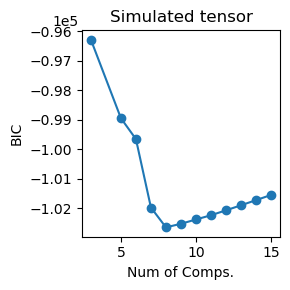

In [22]:
gamma_lists = [gamma_bics]
x_values = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visualize_gamma_lists(gamma_lists, x_values)

In [23]:
for i in range(len(gamma_ranks)):
    print("For gamma {}, the best rank is {} for tensor_cent.".format(i+1, gamma_ranks[i][gamma_bics[i].index(min(gamma_bics[i]))]))

For gamma 1, the best rank is [3 2 3] for tensor_cent.


In [25]:
def estimate_tucker_ranks(tensor, threshold):
    ranks = []
    for mode in range(tensor.ndim):
        matricized = tl.unfold(tensor,mode)
        
        U, S, Vt = svd(matricized, full_matrices=False)

        error_r = 1 - np.sqrt(np.cumsum(S**2) / np.sum(S**2))
        rank = np.where(error_r < threshold)[0][0] + 1
        ranks.append(rank)
    
    return tuple(ranks)

In [33]:
estimated_ranks = estimate_tucker_ranks(tensor_cent, 0.15)
print("Estimated Tucker Ranks for tensor_cent:", estimated_ranks)

Estimated Tucker Ranks for tensor_cent: (3, 2, 3)


In [34]:
def tucker_visualization(factors):
    factor_labels = ["T Cells", "Time", "Patients"]  # Adjust based on your context
    x_labels = [range(f.shape[0]) for f in factors]
    num_components = [f.shape[1] for f in factors]  # Different component numbers per mode
    
    max_components = max(num_components)
    fig, axes = plt.subplots(max_components, len(factors), figsize=(15, 4 * max_components), squeeze=False)
    
    for dim, factor in enumerate(factors):
        for component in range(num_components[dim]):
            ax = axes[component, dim]
            if dim == 0 or dim == 2:
                ax.bar(x_labels[dim], factor[:, component], color='royalblue', alpha=0.8)
            else:
                ax.plot(x_labels[dim], factor[:, component], marker='o', linestyle='-')
            ax.set_title(f"Component {component+1} - {factor_labels[dim]}")
            ax.set_xlabel(factor_labels[dim])
            ax.set_ylabel("Weight")
    
    for dim in range(len(factors)):
        for component in range(num_components[dim], max_components):
            fig.delaxes(axes[component, dim])
    
    plt.tight_layout()
    plt.show()

In [35]:
def visualize_coretensor(core):
    core_tensor = pd.DataFrame({
                           "Index": product(*[np.arange(1, si+1) for si in core.shape]),
                            "Weight": core.flatten(),
                            "Fraction": core.flatten()**2,
                            "Sign": np.sign(core.flatten()),
                        })
    
    core_tensor = core_tensor.sort_values("Fraction", ascending=False)
    core_tensor["Index"] = core_tensor["Index"].astype(str)
    core_tensor["Fraction"] = core_tensor["Fraction"] / np.sum(core_tensor["Fraction"])
    sns.barplot(core_tensor.iloc[:10, :], x="Index", y="Weight", hue="Sign", palette=["#2369BD", "#A9393C"], legend=False)

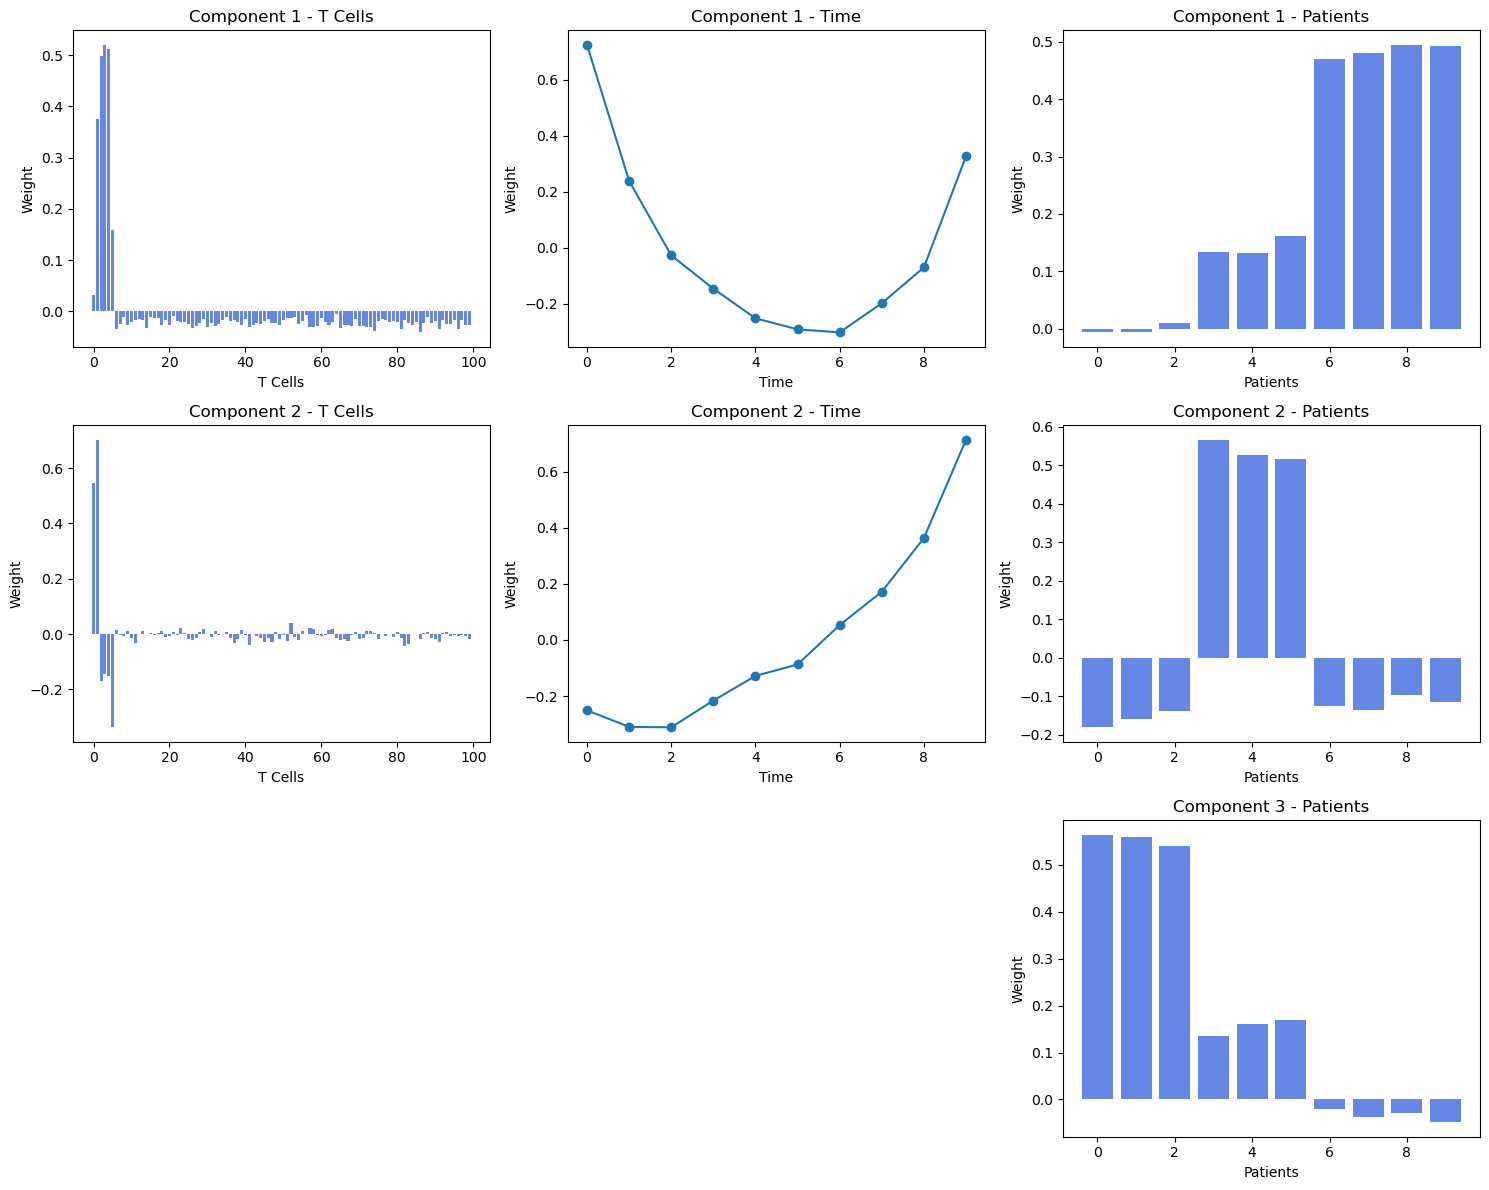

In [44]:
tensor_cent = tl.tensor(tensor_cent)
core_cent, factors_cent = tucker(tensor_cent, rank=[2, 2, 3])
tucker_visualization(factors_cent)

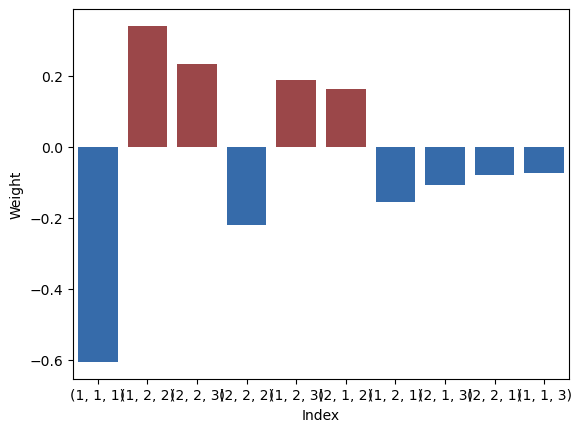

In [45]:
visualize_coretensor(core_cent)